## Using Unsupervised learning for Clustering audio Files


**In this Notebook we are going to see if we are able to cluster male and female voice using unsupervised learning.<br>The flow that the notebook follows is:**
   1. Reading the dataset
   2. Visualizing Waveform and Zero Crossing rate of some sample audio files
   3. Extracting Zero Crossing rate for each audio files
   4. NA value imputation by 
       *  Zero imputation
       * KNN imputation
   5. Applying 
       * PCA on Zero imputation
           * Using Kmeans for clustering
       * PCA on KNN imputation and using the following algorithm for clustering
           * KMeans
           * Agglomerative CLustering
           * DBSCAN
           * MeanShift
       * TSNE on Zero Imputation
            * Using KMeans for clustering
   6. Comparing Results based on Silhoutte score
       

**Silhouette score is used to evaluate the models:**
* Silhoutte score: Silhouette Score is a metric to evaluate the performance of clustering algorithm. It uses compactness of individual clusters (intra cluster distance) and separation amongst clusters (inter cluster distance) to measure an overall representative score of how well our clustering algorithm has performed.
* The Silhouette Coefficient ranges from [-1,1]. 
* The higher the Silhouette Coefficients (the closer to +1), the more is the separation between clusters. 
* If the value is 0 it indicates that the sample is on or very close to the decision boundary between two neighboring clusters whereas a negative value indicates that those samples might have been assigned to the wrong cluster.


In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete,single
from sklearn.metrics import silhouette_score
import IPython.display as ipd
import plotly as py
import plotly.express as px
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Reading Training Dataset

In [2]:
train = pd.read_csv('../input/hindi-speech-classification/dataset/train.csv')

In [3]:
train.head()

,file_id,gender
0,common_voice_hi_26204093,male
1,common_voice_hi_26043935,male
2,common_voice_hi_24632150,male
3,common_voice_hi_24359471,female
4,common_voice_hi_24639127,male


In [4]:
train.isna().sum()

file_id    0
gender     0
dtype: int64

In [5]:
train["gender"].value_counts()

male      1664
female     334
Name: gender, dtype: int64

#### Count plot of male and female files
Data is imbalanced

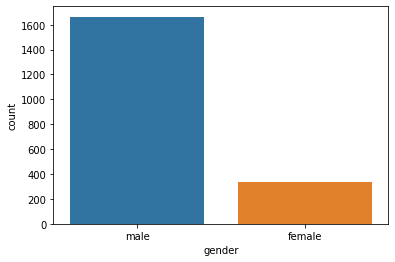

In [6]:
import seaborn as sns
sns.countplot(train["gender"])
plt.show()

In [7]:
train["file_id"] = '../input/hindi-speech-classification/dataset/train/'+ train["file_id"]+'.mp'+'3'
train.head()

,file_id,gender
0,../input/hindi-speech-classification/dataset/t...,male
1,../input/hindi-speech-classification/dataset/t...,male
2,../input/hindi-speech-classification/dataset/t...,male
3,../input/hindi-speech-classification/dataset/t...,female
4,../input/hindi-speech-classification/dataset/t...,male


## 2. Visualizing Waveform and Zero Crossing rate of some sample audio files
1. Wave form: A waveform is a graphical representation of a sound wave as it moves through a medium over time.

2. Zero crossing rate: Zero cross rating is no. of times the signal changes it value from positive to negative or vice versa divided by the length of the frame.

In [8]:
def get_audio_feature_plots(path, target):
    x , sr = librosa.load(path)
    plt.figure(figsize=(20, 5))
    plt.title('Waveplot of '+target)
    librosa.display.waveshow(x, sr=sr)
    plt.show()
    
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title('Zero Crossing Rate of '+target)
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

#### Plotting feature flot for 2 samples of male and female
**Male Sample**

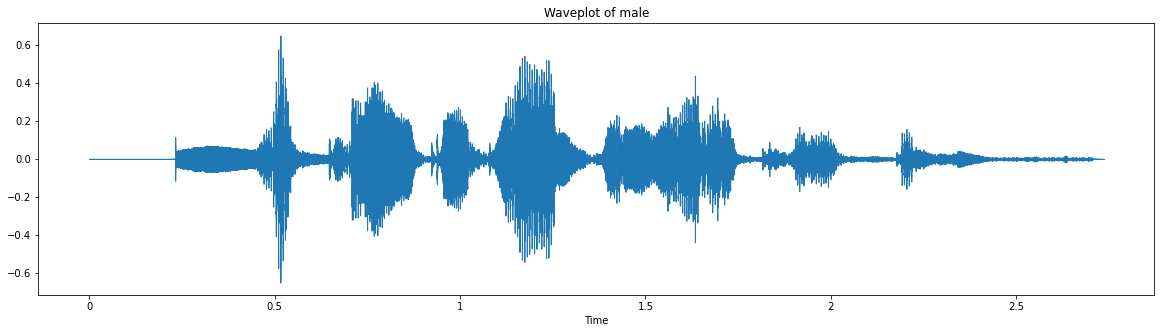

Sum of zero crossing  3305


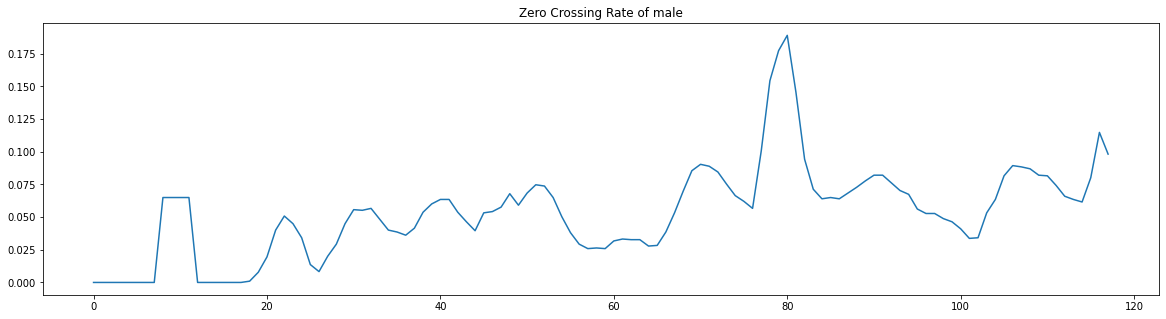

In [9]:
sample_male = train[(train['gender'] == 'male')].sample(2)
get_audio_feature_plots(sample_male["file_id"].values[0],sample_male["gender"].values[0])
ipd.Audio(sample_male["file_id"].values[0])

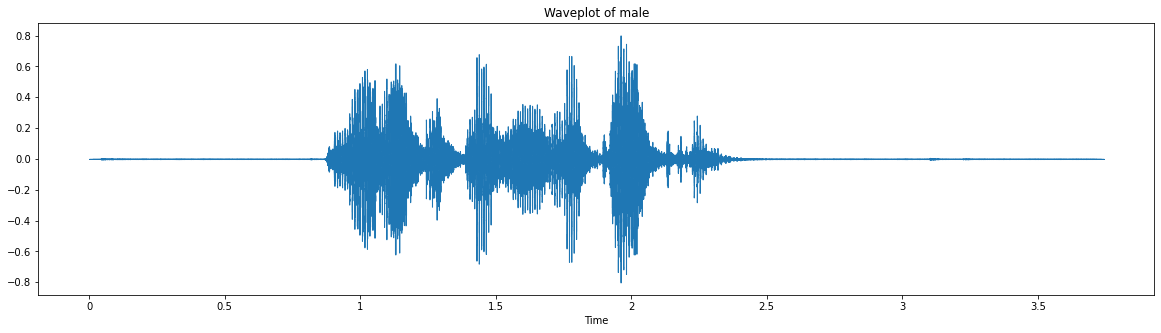

Sum of zero crossing  11001


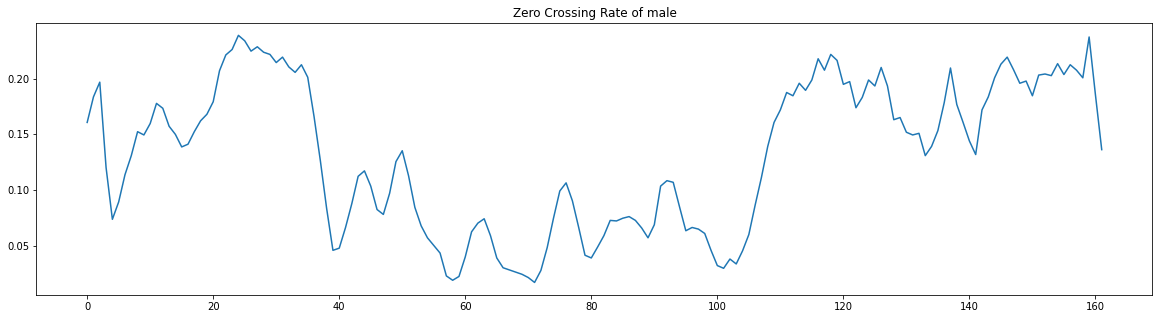

In [10]:
get_audio_feature_plots(sample_male["file_id"].values[1],sample_male["gender"].values[1])
ipd.Audio(sample_male["file_id"].values[1])

**Female Sample**

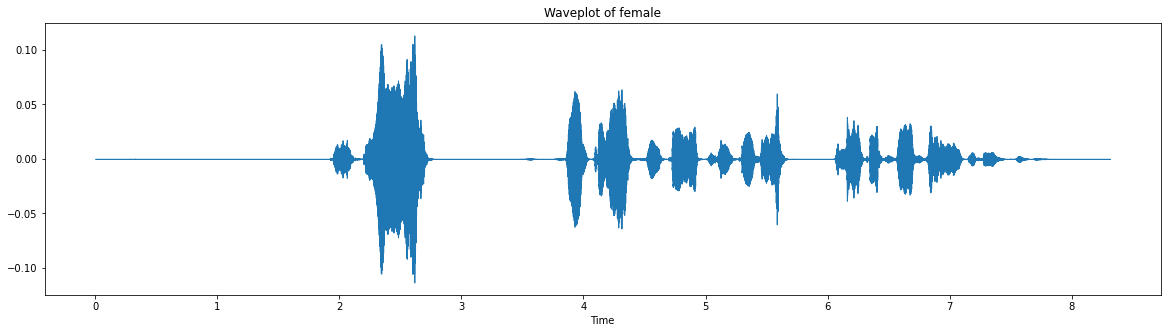

Sum of zero crossing  14471


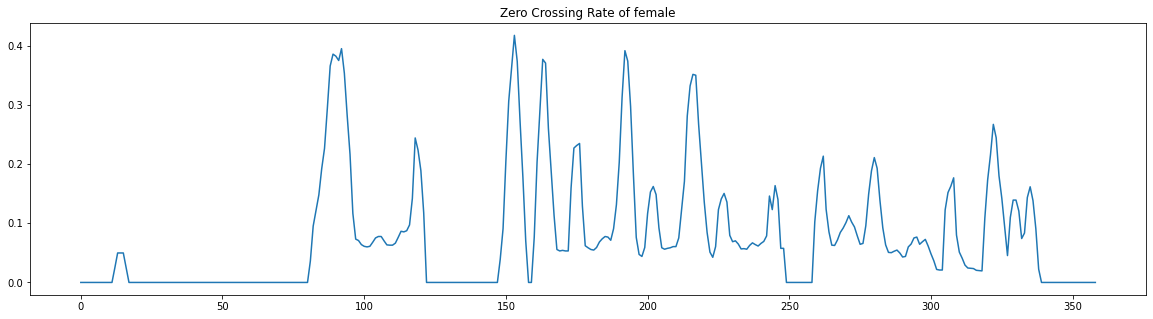

In [11]:
sample_female = train[(train['gender'] == 'female')].sample(2)
get_audio_feature_plots(sample_female["file_id"].values[0],sample_female["gender"].values[0])
ipd.Audio(sample_female["file_id"].values[0])

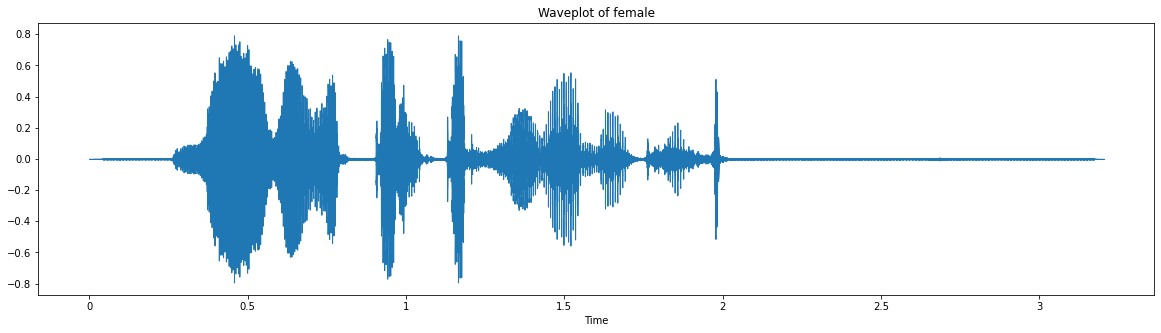

Sum of zero crossing  7169


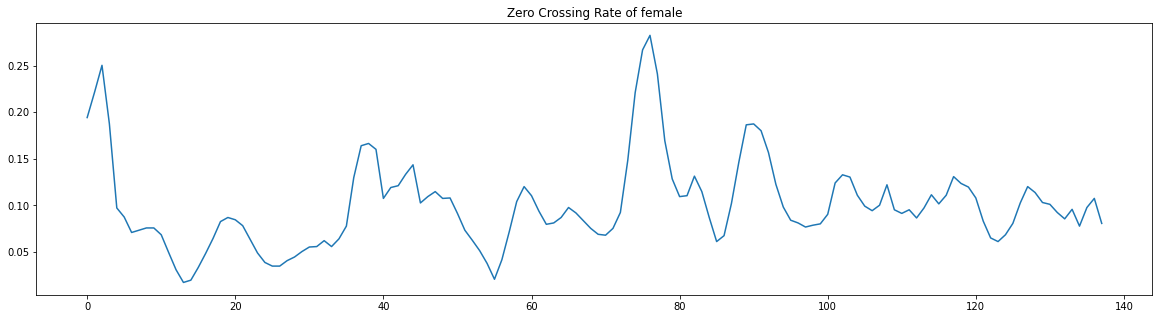

In [12]:
get_audio_feature_plots(sample_female["file_id"].values[1],sample_female["gender"].values[1])
ipd.Audio(sample_female["file_id"].values[1])

## 3. Extracting Zero cross rating for each audio files

In [13]:
def create_zero_cross_rating_features(path):
    zcrs = []
    try:
        x , sr = librosa.load(path, res_type='kaiser_fast')
        zcrs = librosa.feature.zero_crossing_rate(x)[0]
    except:
        print('Error reading audio')
    return zcrs

In [14]:
%%time
X_data = pd.DataFrame(train['file_id'].apply(lambda x: create_zero_cross_rating_features(x)).tolist())
X_data.head()

CPU times: user 3min 10s, sys: 4min 43s, total: 7min 53s
Wall time: 21min 7s


,0,1,2,3,4,5,6,7,8,9,...,429,430,431,432,433,434,435,436,437,438
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.037598,0.037598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.004395,0.058105,0.058105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.043945,0.077637,0.114258,0.156738,0.15625,0.166992,0.180664,0.187500,0.190918,0.190430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.138184,0.296875,0.456055,0.611816,0.62793,0.621094,0.610352,0.571289,0.528809,0.504395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
## Checking for NA values
X_data.isna().sum().sum()

518865

In [16]:
X_data.shape, train.shape

((1998, 439), (1998, 2))

In [17]:
## Saving a copy of data
X_Data_copy=X_data

## 4. NA Values imputation by 
### Zero imputation

In [18]:
Zero_impute = X_data.copy()
Zero_impute = Zero_impute.fillna(0)
Zero_impute.isnull().sum().sum()


0

### KNN imputation

In [19]:
KNN = KNNImputer(n_neighbors=5)
KNN_impute = X_data.copy()
KNN_impute = pd.DataFrame(KNN.fit_transform(KNN_impute))
KNN_impute.isna().sum().sum()

0

## 5. Applying Clustering Algorithms
### 1. PCA on Zero Imputation 


In [20]:
def scaling(data):
    sc = StandardScaler()
    data = sc.fit_transform(data)
    data = pd.DataFrame(data)
    return data
def Principal_Component(data):
    pca = PCA()
    X_pca = pca.fit_transform(data)
    X_pca = pd.DataFrame(X_pca, columns=['PCA_'+str(i) for i in range(len(data.columns))])
    return X_pca,pca


In [21]:
## Scaling the data
Zero_impute_scale = scaling(Zero_impute)

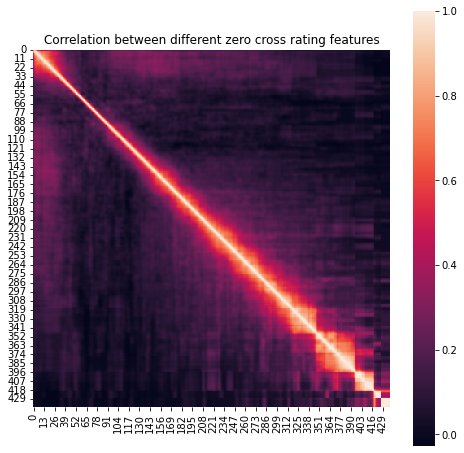

In [22]:
## plotting Correlation between zero cross rating features after Zero imputation
plt.figure(figsize=(8,8))
sns.heatmap(Zero_impute_scale.corr(), vmax=1, square=True)
plt.title('Correlation between different zero cross rating features')
plt.show()

In [23]:
## PCA on Zero impuated features
Zero_impute_pca, pca = Principal_Component(Zero_impute_scale)

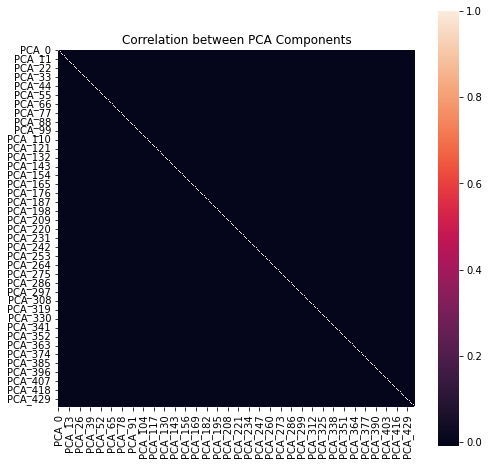

In [24]:
## plotting Correlation between zero cross rating features after applying PCA
plt.figure(figsize=(8,8))
sns.heatmap(Zero_impute_pca.corr(), vmax=1, square=True)

plt.title('Correlation between PCA Components')
plt.show()

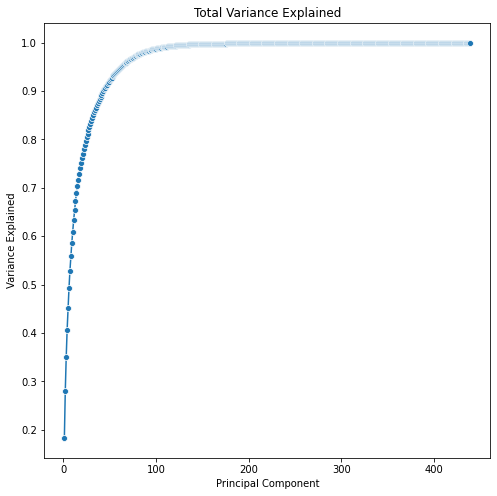

In [25]:
## Plotiing the explained variance for each feature
plt.figure(figsize=(8,8))
sns.lineplot(np.arange(pca.n_components_) + 1,
             np.cumsum(pca.explained_variance_ratio_), 
             marker='o')
plt.title('Total Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### Using kmeans for clustering 

In [26]:
### Finding the no. of components required 
def components_required(n_components,data):
    ## for storing inertia values
    inertia = []
    ## for storing Silhouette score for each cluster
    Sil_score = {}
    ## looping through no. of clusters 
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, random_state = 42)
        y_pred = kmeans.fit_predict(data.iloc[:, :n_components])
        inertia.append(kmeans.inertia_)
        ## silhouette_score requires mininum two clusters to calculate the distance
        if i != 1:
            ## Key would be the no. of cluster and value would be Silhouette Score
            Sil_score[i] = silhouette_score(data.iloc[:, :n_components],y_pred)
            
    plt.figure(figsize=(10,5))
    sns.lineplot(range(1, 11), inertia, marker='o',color='red')
    plt.title('The Elbow Method components:'+str(n_components))
    plt.xlabel('Number of clusters')
    plt.ylabel('Optimal Value')
    plt.show()
    
    print('Silhouette Score for {} components is:'.format(n_components ))
    print(Sil_score)


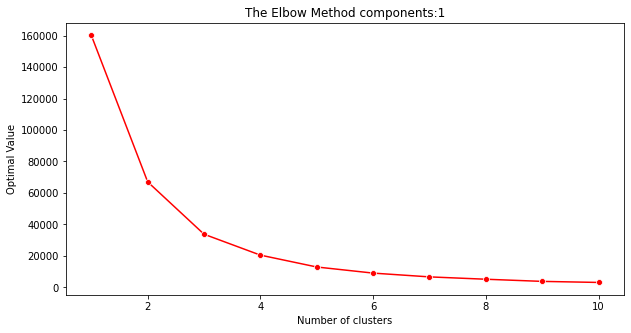

Silhouette Score for 1 components is:
{2: 0.7485853307809796, 3: 0.6847189401598949, 4: 0.6227606851112149, 5: 0.6044056806518407, 6: 0.5798987207049646, 7: 0.5786283989847997, 8: 0.5793055124680783, 9: 0.5772655933646519, 10: 0.55148415900031}


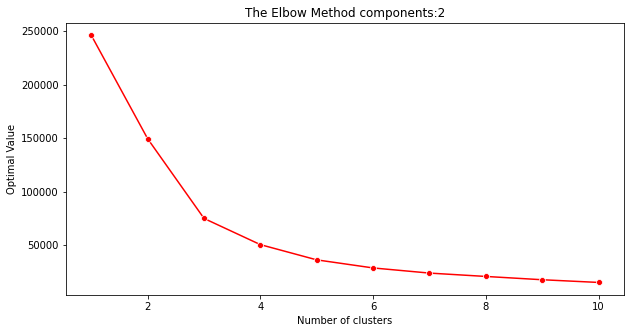

Silhouette Score for 2 components is:
{2: 0.639956780916789, 3: 0.6183919171670703, 4: 0.5690219686089258, 5: 0.5592140923489746, 6: 0.5289945982572867, 7: 0.5302850359416108, 8: 0.5204783756582824, 9: 0.519398768968157, 10: 0.49689725086489905}


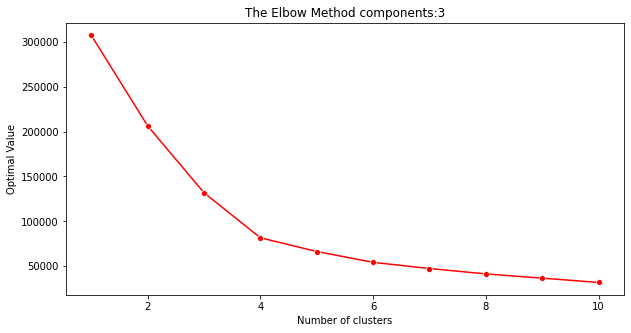

Silhouette Score for 3 components is:
{2: 0.6471269540250693, 3: 0.5723320695712037, 4: 0.5200344860047599, 5: 0.5238216837927012, 6: 0.47902972300890745, 7: 0.4822243182396076, 8: 0.48170914829987993, 9: 0.4839868533244054, 10: 0.4467118338396669}


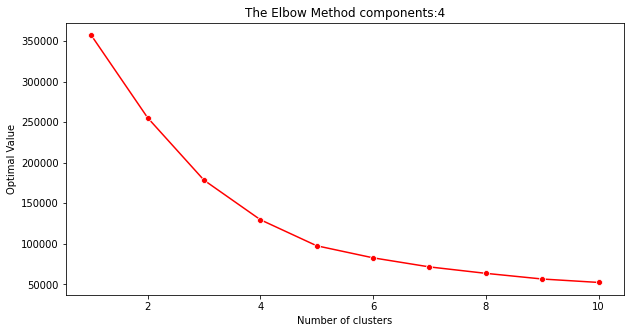

Silhouette Score for 4 components is:
{2: 0.6168785612336114, 3: 0.5440895198202083, 4: 0.46504764091531164, 5: 0.4801392557134154, 6: 0.4865712622828852, 7: 0.4352858515031548, 8: 0.44424603174557314, 9: 0.44954222060198695, 10: 0.4058684114698574}


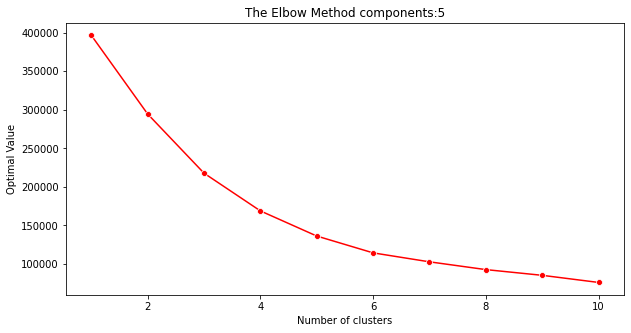

Silhouette Score for 5 components is:
{2: 0.5980742579234786, 3: 0.5171136673463224, 4: 0.4324495412346503, 5: 0.43783021542039086, 6: 0.4469083068407887, 7: 0.4496962224269178, 8: 0.4501688756347827, 9: 0.36731866324624524, 10: 0.3748060440355843}


In [27]:
## Looping for first 5 components
for j in range(1,6):
    components_required(j,Zero_impute_pca)

**Inference:<br>**
1. Looking at the elbow for each component we see that 2 clusters are highly visble when the no. of component is 1. Here I have selected 3 compnents for visualization purpose.
2. However looking at the elbow of 1 component the sihouette score for 2 clusters in 0.74 which is closer to 1 hence it shows higher speperation between the 2 clusters**
3. The Silhouette score of two clusters is the highest in all the cases, hence we can say that the clusters are seperated better when the no. of clusters are 2.

#### Considering 3 components 

In [28]:
## Dataframe for storing Results
results_Zero = pd.DataFrame({'PCA0': Zero_impute_pca['PCA_0'],
                        'PCA1':Zero_impute_pca['PCA_1'],
                        'PCA2':Zero_impute_pca['PCA_2']})

In [29]:
## KMeans
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans3 = kmeans.fit_predict(Zero_impute_pca.iloc[:, :3])
results_Zero["Kmeans_PCA"] = y_kmeans3

In [30]:
## to store Silhoutte score of all the methods for comparison
Silhouette_Score = {}

In [31]:
S_Score = silhouette_score(Zero_impute_pca.iloc[:, :3],y_kmeans3)
Silhouette_Score["KMean PCA on Zero Imputation"] = S_Score
print("Sihhoutette Score of Kmeans ",S_Score)

Sihhoutette Score of Kmeans  0.6471269540250693


In [32]:
fig = px.scatter_3d(results_Zero, 
                    x='PCA0', 
                    y='PCA1',
                    z = 'PCA2',
                    color='Kmeans_PCA',
                    opacity=0.5
                   )
fig.show()

### 2. PCA on KNN imputation

In [33]:
## Scaling KNN imputed features
KNN_impute_scale = scaling(KNN_impute)

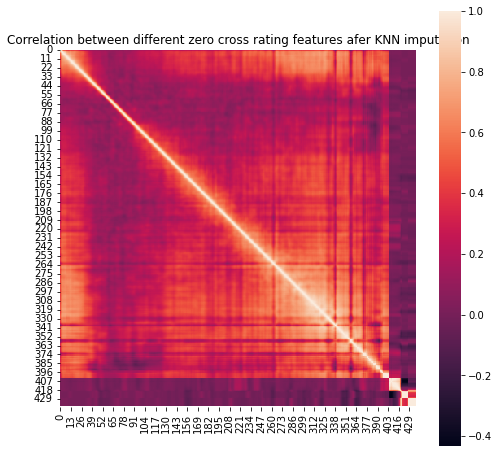

In [34]:
## plotting Correlation between KNN imputed features
plt.figure(figsize=(8,8))
sns.heatmap(KNN_impute_scale.corr(), vmax=1, square=True)
plt.title('Correlation between different zero cross rating features afer KNN imputation')
plt.show()

In [35]:
## Applying PCA on KNN imputed features
KNN_impute_pca,pca = Principal_Component(KNN_impute_scale)

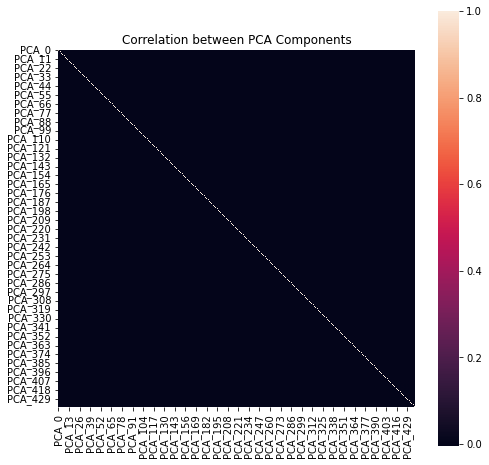

In [36]:
## plotting Correlation between KNN imputed features after applying PCA
plt.figure(figsize=(8,8))
sns.heatmap(KNN_impute_pca.corr(), vmax=1, square=True)

plt.title('Correlation between PCA Components')
plt.show()

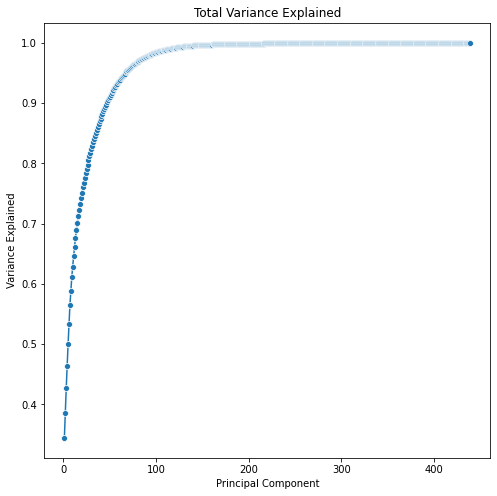

In [37]:
plt.figure(figsize=(8,8))
sns.lineplot(np.arange(pca.n_components_) + 1,
             np.cumsum(pca.explained_variance_ratio_), 
             marker='o')
plt.title('Total Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### Using Kmeans for Clustering

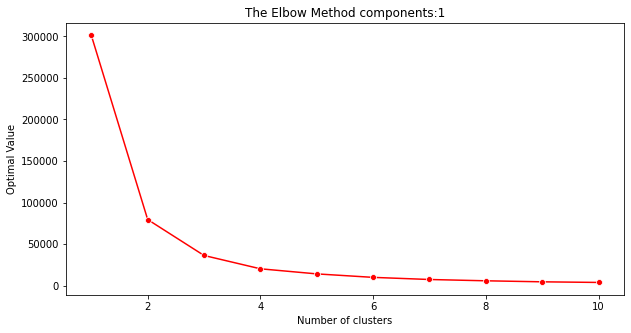

Silhouette Score for 1 components is:
{2: 0.6690383103595332, 3: 0.6126650797160923, 4: 0.615966250849231, 5: 0.5923879417743271, 6: 0.5767138518912476, 7: 0.5773507492777119, 8: 0.5567374583483945, 9: 0.5531628816249773, 10: 0.5416785152305935}


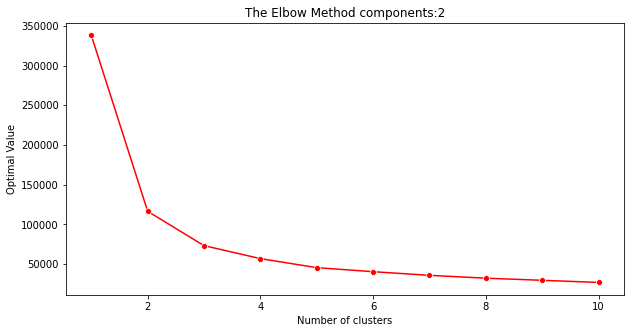

Silhouette Score for 2 components is:
{2: 0.6110438732625596, 3: 0.500005291607023, 4: 0.47088017764004275, 5: 0.47055414664128414, 6: 0.4488691814065779, 7: 0.43636715327900777, 8: 0.39124207935283456, 9: 0.38337552986034656, 10: 0.3919226811990329}


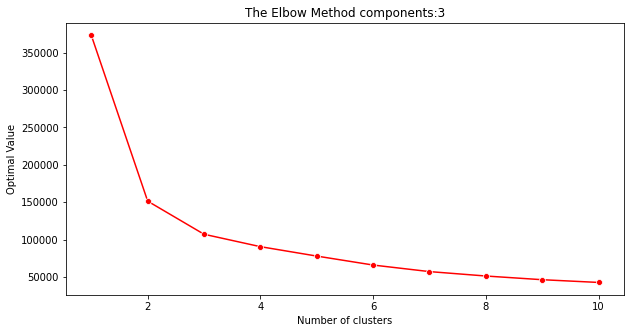

Silhouette Score for 3 components is:
{2: 0.5871410246616261, 3: 0.46042875294366314, 4: 0.42419831245799366, 5: 0.42487673534545967, 6: 0.42494413510023565, 7: 0.4328761435561949, 8: 0.38973740629587517, 9: 0.3909135506267576, 10: 0.39070949999136845}


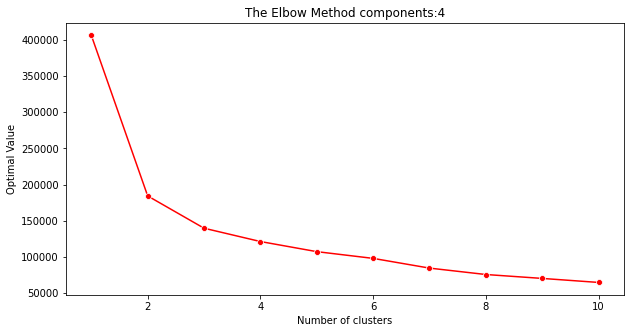

Silhouette Score for 4 components is:
{2: 0.5589807038910614, 3: 0.41144758542373955, 4: 0.37811412207994727, 5: 0.37973704091093996, 6: 0.3736322967675475, 7: 0.37493700738523367, 8: 0.377416859096355, 9: 0.35423377427970376, 10: 0.3498955367997301}


In [38]:
## The function was defined before
for j in range(1,5):
    components_required(j,KNN_impute_pca)

**Inference**
1. The inference are quite similar to that of Zero imputation
2. Here as weel i have selected 3 components as input features


In [39]:
## For storing results of each algorithm
results_KNN = pd.DataFrame({'PCA0': KNN_impute_pca['PCA_0'],
                        'PCA1':KNN_impute_pca['PCA_1'],
                        'PCA2':KNN_impute_pca['PCA_2']})

In [40]:
## KMeans
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_knn3 = kmeans.fit_predict(KNN_impute_pca.iloc[:, :3])
results_KNN["Kmeans"] = y_knn3

In [41]:
S_Score = silhouette_score(KNN_impute_pca.iloc[:, :3],y_knn3)
Silhouette_Score["KMeans PCA on KNN Imputation"] = S_Score
print("Sihhoutette Score of Kmeans is",S_Score)

Sihhoutette Score of Kmeans is 0.5871410246616261


In [42]:
import plotly.express as px

fig = px.scatter_3d(results_KNN, 
                    x='PCA0', 
                    y='PCA1',
                    z = 'PCA2',
                    color='Kmeans',
                    opacity=0.5
                   )
fig.show()

#### Using Agglomerartive clustering


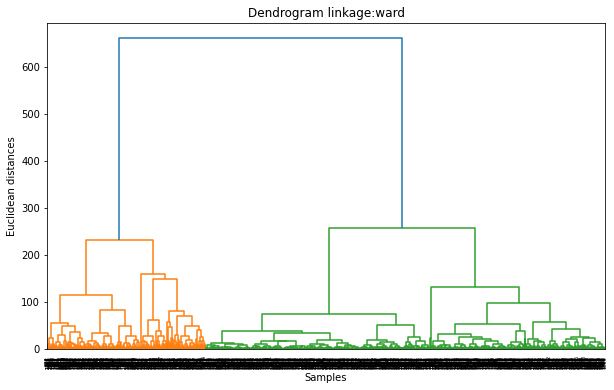

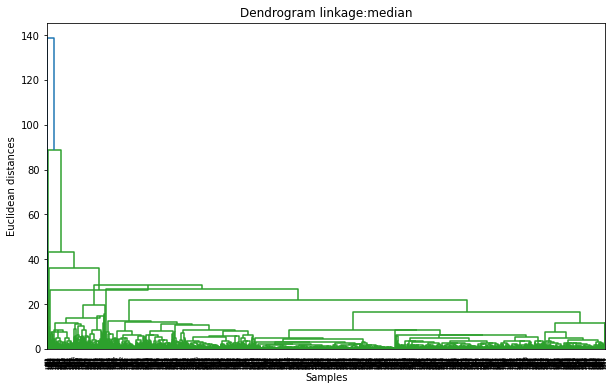

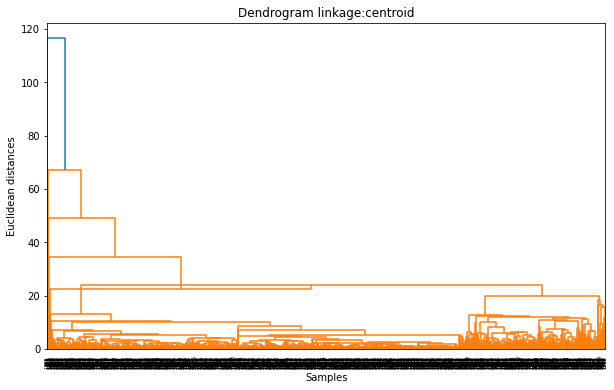

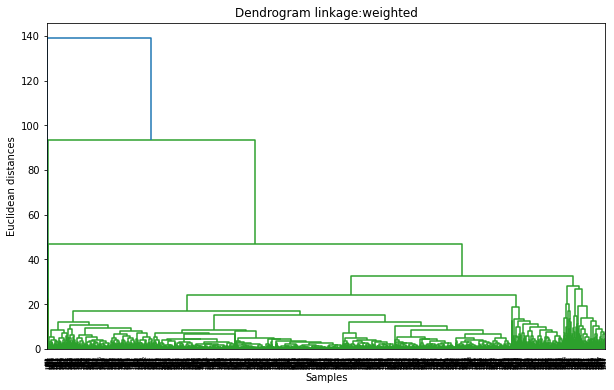

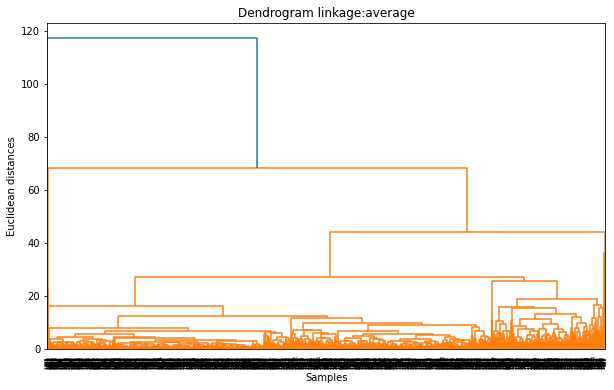

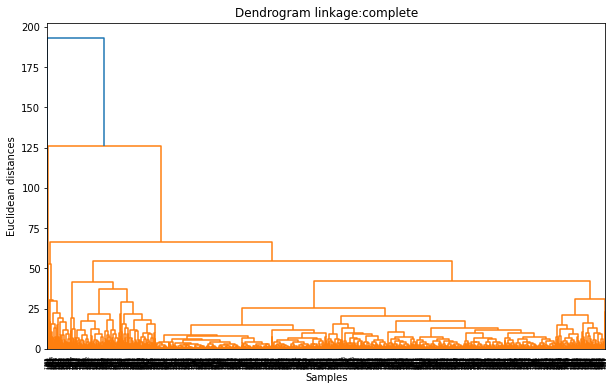

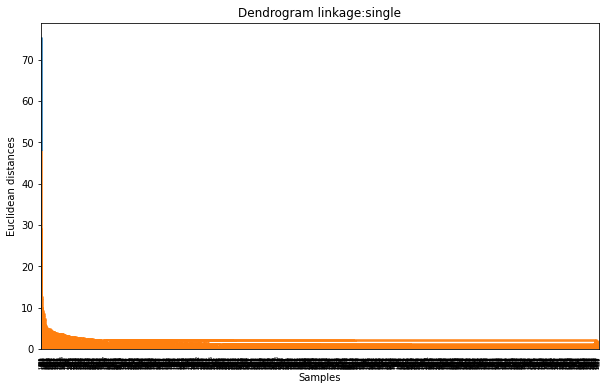

In [43]:
## Finding which method of linkage determines the clusters well
linkage = ['ward', 'median', 'centroid', 'weighted', 'average', 'complete', 'single']
X = KNN_impute_pca.iloc[:, :3]
for i in linkage:
    plt.figure(figsize=(10,6))
    dend = sch.dendrogram(sch.linkage(X, method = i))
    plt.title('Dendrogram linkage:'+ i)
    plt.xlabel('Samples')
    plt.ylabel('Euclidean distances')
    plt.show()

**Inference**
1. Looking at the dendrogram we see that Ward method is the one where we can see 2 clusters are highly seperated from each other hence the method is ward and the no. of clusters is 2

In [44]:
## Making predictions using Ward method 
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward',affinity='euclidean')
y_agglomerative = clustering.fit_predict(X)
results_KNN["Agglomerative Clustering"] = y_agglomerative

In [45]:
S_Score = silhouette_score(KNN_impute_pca.iloc[:, :3],y_agglomerative)
Silhouette_Score["Agglomeartive CLustering PCA on KNN imputation"]= S_Score
print("Sihhoutette Score of Agglomerative clustering ",S_Score)

Sihhoutette Score of Agglomerative clustering  0.5738380179520876


In [46]:
fig = px.scatter_3d(results_KNN, 
                    x='PCA0', 
                    y='PCA1',
                    z = 'PCA2',
                    color='Agglomerative Clustering',
                    opacity=0.8
                   )
fig.show()

### Using DBScan for clustering

In [47]:
X= KNN_impute_pca.iloc[:, :3]
DBScan = DBSCAN(eps = 3.25)
y_DBscan = DBScan.fit_predict(X) 
results_KNN["DBscan"] = y_DBscan
Sil_Score_DBscan = silhouette_score(X,y_DBscan)

In [48]:
S_Score = silhouette_score(X,y_DBscan)
Silhouette_Score["DBScan PCA on KNN imputation"]= S_Score
print("Sihhoutette Score of  DBScan is",S_Score)

Sihhoutette Score of  DBScan is 0.429349440960882


In [49]:
fig = px.scatter_3d(results_KNN, 
                    x='PCA0', 
                    y='PCA1',
                    z = 'PCA2',
                    color='DBscan',
                    opacity=0.5
                   )
fig.show()

### Using Meanshift for clustering

In [50]:
clustering = MeanShift()
y_MeanShift = clustering.fit_predict(X)
results_KNN["MeanShift"] = y_MeanShift

In [51]:
eS_Score = silhouette_score(X,y_MeanShift)
Silhouette_Score["Mean Shift PCA on KNN imputation"]= S_Score
print("Sihhoutette Score of Meansshift is",S_Score)

Sihhoutette Score of Meansshift is 0.429349440960882


In [52]:
results_KNN["MeanShift"].value_counts()

0    1587
1     186
7     148
2      56
6      13
3       4
5       1
9       1
8       1
4       1
Name: MeanShift, dtype: int64

**Inference: MeanShift algorithm is determing 9 clusters**

In [53]:
import plotly.express as px

fig = px.scatter_3d(results_KNN, 
                    x='PCA0', 
                    y='PCA1',
                    z = 'PCA2',
                    color=y_MeanShift,
                    opacity=0.8
                   )
fig.show()

### Applying TSNE : t-distributed Stochastic Neighbor Embedding on Zero Imputation

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 3)
Zero_impute_tsne1 = tsne.fit_transform(Zero_impute)

In [55]:
Zero_impute_tsne1.T[0].shape

(1998,)

In [56]:
Zero_impute_tsne = pd.DataFrame({'C0':Zero_impute_tsne1.T[0],'C1':Zero_impute_tsne1.T[1],
                                'C2':Zero_impute_tsne1.T[2]})
                    

In [57]:
Zero_impute_tsne

,C0,C1,C2
0,7.880681,-23.189192,-34.279926
1,29.650549,2.053531,-1.518493
2,25.159155,25.505011,-38.081306
3,-8.121265,-6.661470,32.424095
4,-20.722750,39.506092,21.498463
...,...,...,...
1993,-39.906063,20.093040,10.772691
1994,18.403074,-19.474379,-23.463631
1995,-31.479002,-28.154774,32.748268
1996,-1.165434,20.107178,7.535137


### USing KMeans Clusetring
#### Considering 1 TSNE Component

In [58]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_tsne = kmeans.fit_predict(Zero_impute_tsne.iloc[:,:1])

In [59]:
S_Score= silhouette_score(Zero_impute_tsne.iloc[:,:1],y_tsne)
Silhouette_Score["KMeans TSNE 1 component"] = S_Score
print("Sihhoutette Score of Kmeans 1 components is",S_Score)

Sihhoutette Score of Kmeans 1 components is 0.5841707


#### Considering 2 TSNE components

In [60]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_tsne = kmeans.fit_predict(Zero_impute_tsne.iloc[:,:2])

In [61]:
S_Score= silhouette_score(Zero_impute_tsne.iloc[:,:2],y_tsne)
Silhouette_Score["KMeans TSNE 2 Components"] = S_Score
print("Sihhoutette Score of Kmeans 2 components is",S_Score)

Sihhoutette Score of Kmeans 2 components is 0.3972367


In [62]:
px.scatter(Zero_impute_tsne,x = 'C0',y = "C1",color = y_tsne)

### Considering 3 TSNE components

In [63]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_tsne = kmeans.fit_predict(Zero_impute_tsne.iloc[:,:3])

In [64]:
S_Score= silhouette_score(Zero_impute_tsne.iloc[:,:3],y_tsne)
Silhouette_Score["KMeans TSNE 3 Components"] = S_Score
print("Sihhoutette Score of Kmeans 3 components is",S_Score)

Sihhoutette Score of Kmeans 3 components is 0.32312047


In [65]:
import plotly.express as px

fig = px.scatter_3d(Zero_impute_tsne, 
                    x='C0', 
                    y='C1',
                    z = 'C2',
                    color=y_tsne,
                    opacity=0.8
                   )
fig.show()

## 6. Comparing Results based on Silhoutte score

In [66]:
Silhouette_Score

{'KMean PCA on Zero Imputation': 0.6471269540250693,
 'KMeans PCA on KNN Imputation': 0.5871410246616261,
 'Agglomeartive CLustering PCA on KNN imputation': 0.5738380179520876,
 'DBScan PCA on KNN imputation': 0.429349440960882,
 'Mean Shift PCA on KNN imputation': 0.429349440960882,
 'KMeans TSNE 1 component': 0.5841707,
 'KMeans TSNE 2 Components': 0.3972367,
 'KMeans TSNE 3 Components': 0.32312047}

In [67]:
Score = pd.DataFrame({'Models':Silhouette_Score.keys(),'Score':Silhouette_Score.values()})
Score.sort_values(by = "Score",ascending=False)

,Models,Score
0,KMean PCA on Zero Imputation,0.647127
1,KMeans PCA on KNN Imputation,0.587141
5,KMeans TSNE 1 component,0.584171
2,Agglomeartive CLustering PCA on KNN imputation,0.573838
3,DBScan PCA on KNN imputation,0.429349
4,Mean Shift PCA on KNN imputation,0.429349
6,KMeans TSNE 2 Components,0.397237
7,KMeans TSNE 3 Components,0.323120


**Inference:
Kmeans Model on zero imputated data seperates the clusters better than other models as the Silhouette score is maximum as compared to other models.**